In [95]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C


import cntk.io.transforms as xforms
import cntk.tests.test_utils
c.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
import glob
%matplotlib inline

In [143]:
data_dir = r'E:\Temp\lfw'
data_dir = r'E:\Temp\MNIST'

# down data from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# model dimensions
img_h = 28
img_w  = 28
input_dim = img_h * img_w
num_channels = 3
num_classes  = 0
latent_dim = 32

e_kernel_1 = (5,5)
e_stride_1 = (2,2)
e_filter_1 = 1
e_filter_2 =  128

isFast = True
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 64
num_sweeps_to_train_with = 20 if isFast else 100
num_samples_per_sweep = 60000
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size

map_file = data_dir + '\\cntk_image_data.tsv'

In [133]:
# prepare CNTK imageReader data
with open(map_file, 'w') as out:
    for f in glob.glob(data_dir + '\\*\\*.jpg'):
        out.write('{}\t0\n'.format(f))

def plot_image(img):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

    axes[0].imshow(img, cmap="gray")
    axes[0].axis("off")
    
    axes[1].imshow(img, cmap="gray")
    axes[1].set_title("2")
    axes[1].axis("off")


In [96]:
def create_reader_mnist(path, is_training):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=10, is_sparse=False),
        input   = C.io.StreamDef(field='features', shape=784, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

def create_reader_lfw(map_file, train, is_training):
    print("Reading map file:", map_file)    

    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if train and False:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')        
    ]
    # deserializer
    return c.io.MinibatchSource(c.io.ImageDeserializer(map_file, c.io.StreamDefs(
        input = c.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = c.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [150]:
def encoder(input):    
    with C.layers.default_options(init=C.normal(scale=0.02)):

        dfc_dim = 1024
        df_dim = 64

        print('Discriminator convolution input shape', input.shape)
        x = C.reshape(input, (1, img_h, img_w))

        h0 = C.layers.Convolution2D(e_kernel_1, e_filter_1, strides=e_stride_1, pad=True, activation=C.relu)(x)        
        print('h0 shape :', h0.shape)

        h1 = C.layers.Convolution2D(e_kernel_1, e_filter_2, strides=e_stride_1, pad=True, activation=C.relu)(h0)        
        print('h1 shape :', h1.shape)

        z = C.layers.Dense(latent_dim, activation=C.relu)(h1)        
        print('h2 shape :', z.shape)

        return z
    
def decoder(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        print('Generator input shape: ', z.shape)
        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        gfc_dim = 1024
        gf_dim = 64
        
        h1 = C.layers.Dense([e_filter_2, s_h4,  s_w4], activation=C.relu)(z)        
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(e_kernel_1,
                                  num_filters=e_filter_2,
                                  strides=e_stride_1,
                                  pad=True,
                                  output_shape=(s_h2, s_w2), activation=C.relu)(h1)        
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(e_kernel_1,
                                  num_filters=e_filter_1,
                                  strides=e_stride_1,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)

        return C.reshape(h3, img_h * img_w)

network = {}


def create_network():
    input = C.input_variable(input_dim)
    label = C.input_variable(input_dim)
    network['input'] = input
    network['label'] = label

    # Create the model function
    z = encoder(input/255.0)
    network['z'] = z    
    output = decoder(z)    
    network['output'] = output
    target = input/255.0
    loss = C.losses.squared_error(target, output)
    error  = C.classification_error(output, target)
    network['loss'] = loss
    network['error'] = error
    return network



In [156]:
def train(train_file, test_file):
    create_network()
    
    loss = network['loss']
    output = network['output']
    error = network['error']
    input = network['input']
    label = network['label']
    
     # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.9126265014311797, minibatch_size)
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(output.parameters,
                         lr=lr_schedule, momentum=momentum_schedule)

    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(output, (loss, error), learner, progress_printer)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : train_file.streams.input,
        label  : train_file.streams.labels
    }
    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = train_file.next_minibatch(minibatch_size, input_map = input_map)

        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples

    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))

    
    

In [ ]:
train_file = create_reader_mnist(os.path.join(data_dir + '\Train-28x28_cntk_text.txt'), True)    

train(train_file, None)

Discriminator convolution input shape (784,)
h0 shape : (1, 14, 14)
h1 shape : (128, 7, 7)
h2 shape : (32,)
Generator input shape:  (32,)
h1 shape (128, 7, 7)
h2 shape (128, 14, 14)
h3 shape : (1, 28, 28)
 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------


C:\Users\serajago.FAREAST\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Learning rate per 1 samples: 3e-05
      181        181      0.769      0.769            64
      181        181      0.727      0.706           192
      181        181      0.842      0.928           448
      181        181      0.926          1           960
      180        179      0.964          1          1984
      160        141      0.982          1          4032
      111       62.6      0.759      0.539          8128


In [130]:
train = create_reader_mnist(os.path.join(data_dir + '\Train-28x28_cntk_text.txt'), False)
data = train.next_minibatch(1)

In [129]:
decoder(encoder(data[train.streams.input]))

Discriminator convolution input shape (1, 1, 784)
h0 shape : (1, 14, 14)
h1 shape : (128, 7, 7)
h2 shape : (32,)
Generator input shape:  (32,)
h1 shape (128, 7, 7)
h2 shape (128, 14, 14)
h3 shape : (1, 28, 28)


Composite(Reshape):  -> Output('Reshape2367_Output_0', [], [784])

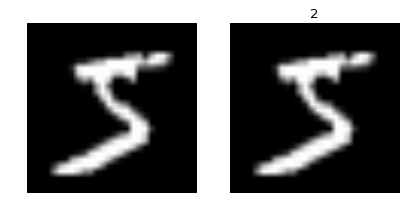

In [83]:
plot_image(data[train.streams.input].data.asarray()[0,:,:].reshape(28,28))

In [65]:
data[0,:,:]

TypeError: unhashable type: 'slice'